# Expanding network connectivity modeling to recover simulated task activity using connectivity matrix


Set up environment

In [1]:
from collections import OrderedDict
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

Import custom modules

In [3]:
import sys
sys.path.append('../')
sys.path.append('../../utils/')

# Helper functions for eGLM 
from eGLM_helpers import phi, run_ucr_glm, run_ext_glm, make_stimtimes, sim_network_task_glm, get_true_baseline, plot_sim_network_glm


## Neural network model

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf) and [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

Note: Extending the GLM in this way is intended to account for the connectivity between nodes and how **task** activity in the previous step affects task activity in the current step for a given node. Is the same thing as 'subtracting out' resting state to look at the remaining task activity?


## Baseline simulation

First we simulate a topdown task that stimulates nodes only in the hub network. No noise is added to this simulation. It is intended to serve as a baseline to compare the changes for all the tests below. 

The plot below will serve as a template for several tests later in this notebook.
The x-axis denotes each node and the y-axis the regression coefficient of task activity for each nodes' time series. The blue line shows the parameters using the classic GLM framework (cGLM) and the yellow line are the parameter estimates when the time series is corrected for its connectivity with the rest of the network using the extended GLM equation above (eGLM). The vertical lines denote community boundaries. In the baseline simulation there is one hub network and two local networks. The horizontal line depicts the expected magnitude of the task parameter accounting for that nodes connectivity and stimulation status (detailed below).

In [4]:
base_sim = sim_network_task_glm(noise=None)

Text(85, 1.75, 'Local 2')

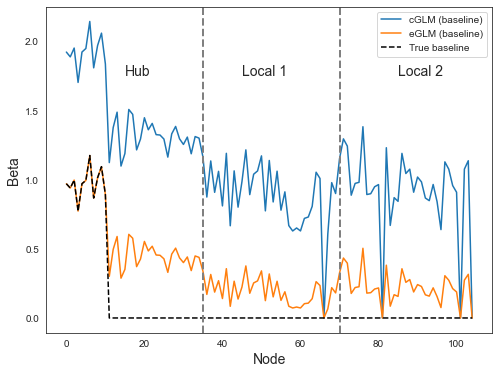

In [6]:
plot_sim_network_glm(data = base_sim, base_label = "True baseline")
plt.text(x = 15, y = 1.75, s = "Hub", fontsize = 14)
plt.text(x = 45, y = 1.75, s = "Local 1", fontsize = 14)
plt.text(x = 85, y = 1.75, s = "Local 2", fontsize = 14)

With the change in the GLM equation the task parameter estimates can get change in two ways:

- bias [change in mean]: the relationship between the timeseries and task regressor becomes stronger or weaker on average
- variance [more variable estimates]: the relationship between the timeseries and the task regressor varies more across nodes. Since the task regressor is the same for all nodes (we wouldn't empirically know which nodes are stimulated by it) this increased variability would have to be due to increased variability in the timeseries across nodes. 

## Different noise levels

In [6]:
td_stimtimes_0_5 = make_stimtimes(Tmax=10000, dt=1, stim_nodes=base_sim['stim_nodes'], stim_mag=0.5)

In [7]:
noise_ts = {}

noise_sds = [0, .5, 1, 2, 5]

In [8]:
for noise_sd in noise_sds:
    var_name = "noise_"+str(noise_sd)
    noise_ts[var_name] = sim_network_task_glm(W = base_sim['W'],Tmax=10000,dt=1,g=1,s=1,tau=1, noise=1, noise_scale = noise_sd)
    

First we examine the effect of different amounts of noise. When the noise parameter is turned on a random number from a normal distribution with a mean of 0 and specified standard deviation is added to the activity level at each time point. The amount of noise is changed by modifying the variance of this distribution and leaving the mean at 0. 

Below we plot time series for a stimulated and non-stimulated node for varying levels of noise. The time series without noise points out the amplification of the task signal through connections to the rest of the network. This is why the activity for a non-stimulated node (right plot) is not at 0 for the whole task either. Importantly, this suggests that the "correct" baseline that the task activity parameter estimates should be compared to is not the stimulus timing for each node but the remaining relationship between the time series and task timing once the amplification through the rest of the network is accounted for.

Text(0.5, 1.0, 'Non-stimulated node')

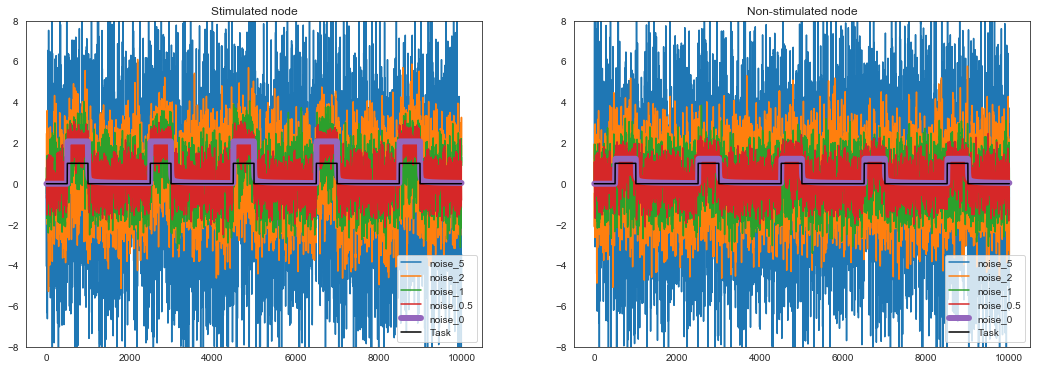

In [9]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6

#Plot same stimulated node's timeseries with and without noise
fig,a =  plt.subplots(1,2)
curns = [0, 21]
rkeys = list(noise_ts.keys())
rkeys.reverse()
for i in range(2):
    curn = curns[i]
    for j in rkeys:
        if j == 'noise_0':
            a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), noise_ts[j]['taskdata'][curn,:], linewidth = 6,label=j)
        else:
            a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), noise_ts[j]['taskdata'][curn,:],label=j)
    a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), td_stimtimes_0_5[0], label="Task", color="black")
    a[i].legend(loc="best")
    a[i].set_ylim([-8,8])
    
a[0].set_title("Stimulated node")
a[1].set_title("Non-stimulated node")

The effect of adding noise to the timeseries has different effects on the task parameter estimates using the two approaches.  

For the classic GLM:
- without noise the task regressors capture the relationship between task timing and the activity level that is amplified by recurring connections in the network.
- with noise the overestimation of the task regressor that reflects the amplification is reduced because the systematic relationship between the task regressor and the node's activity is destroyed by noise. The parameter estimates reduce with increasing noise.

For the extended GLM
- without noise the task regressors now capture the relationship between the timeseries that is residualized from all other nodes' recurring activity and the residualized task regressor that is transformed using the same matrix applied to the node's time series. These 'corrected' estimates now match the expected baseline relationship between the timeseries and task regressor when the effects of all other regressors are removed.
- with noise the change parameter estimates compared to noiseless data is not monotonic. The estimates decrease even further initially and then increase with increasing noise though always remaining lower than estimates for noiseless data. Moreover, estimates for non-stimulated nodes are overcorrected for small amounts of noise but this disappears for larger amounts of noise. Overall, corrected estimates for noisy data match the baselines similarly well but the baselines are lower as well.

For baselines:
- without noise the baseline reflects the relationship between the residualized time series and residualized task regressor for stimulated nodes (and 0 to speed up computation for non-stimulated nodes).
- with noise they always decrease but the decrease is not monotonically related to the amount of noise. The addition of a little bit noise reduces the baselines for even stimulated nodes to almost 0. The baselines for stimulated nodes increase and approach the noiseless baseline with increasing noise but always remain lower.

I'm not sure what would be an appropriate level of noise for real data would be.

There are at least two things that need clarification based on these results:
- The change in baselines with noise
- The overcorrection of non-stimulated node parameter estimates (though keep in mind that due to the size of the network the baseline for non-stimulated nodes is not computed but assumed to be 0. This should be re-examined with a smaller network where the true baselines are computed for the non-stimulated nodes the same way they are for stimulated nodes)

In [10]:
values = ["C"+str(x) for x in range(len(noise_ts.keys()))]
col_lookup = dict(zip(rkeys, values))

Text(0.5, 1.0, 'Extended GLM')

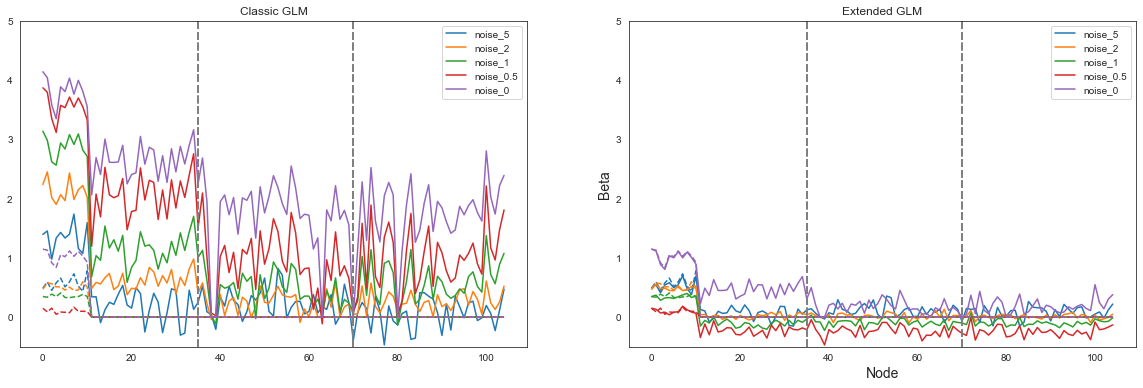

In [14]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6
fig, a =  plt.subplots(1,2)

beta_keys = ['ucr_betas', 'ext_betas']
for i, bk in enumerate(beta_keys):
    for j in rkeys:
        a[i].plot(noise_ts[j][bk], label = j, color = col_lookup[j])
        
        baseline_vec = get_true_baseline(noise_ts[j])

        a[i].plot(baseline_vec, 
                  color = col_lookup[j], linestyle = '--')
    
        for n in range(1,3):
            a[i].axvline(x=35*n,linewidth=2, color='gray', ls = "--")
        a[i].legend(loc="best")
        a[i].set_ylim([-.5,5])
        
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
a[0].set_title("Classic GLM")
a[1].set_title("Extended GLM")
#fig.suptitle('Standardized parameters')

### Changes in baselines with noise

For **stimulated nodes*** baselines are calculated by:
1. residualize the time series of activity regressing the time series on all the regressors except the task regressor
2. calculate the residualizing matrix from the projection matrix of this model
3. apply the residualizing matrix onto the task regressor 
4. apply the inverse of the transform applied to the original task regressor
5. regress the residualized time series on this residualized and inverse transformed task regressor

\* for non-stimulated nodes the baseline is assumed to be 0 for computation speed.

Below we plot the residualized activity and the residualized task regressor (i.e. the two components of the baselines for stimulated nodes) for one stimulated node for three different noise levels and one "task-on" block to understand the change in the relationship between these two components.

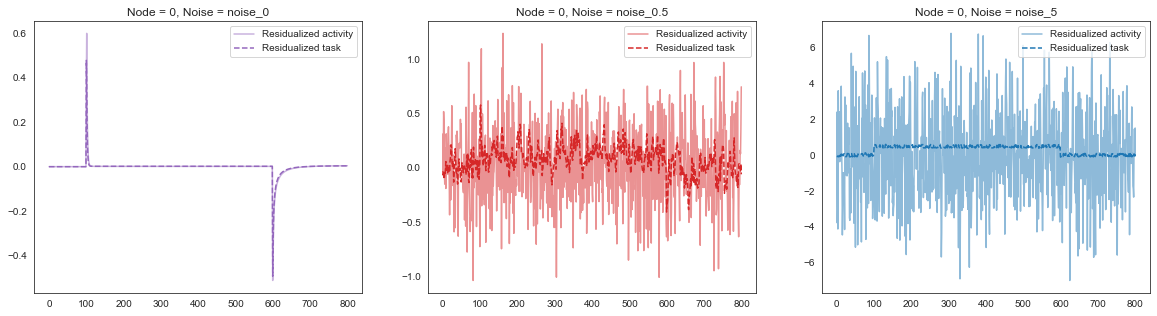

In [12]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5

fig, a = plt.subplots(1, 3)
noise_levels = ['noise_0', 'noise_0.5', 'noise_5']
curn = 0
xrange = range(400,1200)

for i, cur_noise in enumerate(noise_levels):
    res_y, m_task_reg = get_res_taskreg(noise_ts[cur_noise], curn)
    a[i].plot(res_y[xrange], label = 'Residualized activity', color = col_lookup[cur_noise], alpha = 0.5)
    a[i].plot(m_task_reg[xrange], label = 'Residualized task', ls = '--', color = col_lookup[cur_noise])
    a[i].set_title("Node = "+str(curn)+", Noise = "+cur_noise) 
    a[i].legend(loc = "upper right")

- Without noise the residualized time series shows an interesting/odd pattern of a peak at $t-1$ before the task comes on and a dip at $t-1$ before the task goes off. This is due to the network's total activity in the previous time point. Simply put, the residualization of the stimulated node's activity time series can be thought of as the subtraction of the rest of the network's activity level in the previous time point from a stimulated node (because as the equation above describes we are modeling activity in the next time point). 
    - At $t$ when task comes on both the stimulated node's and the rest of the networks activity increases. The residualized time series captures the positive difference between this increased activity of the stimulated node and the inactive network's activity at the previous time point before the task comes on leading to a peak.
    - At $t$ when task comes off the stimulated node's activity decreases. The residual activity level captures the negative difference between the lower stimulated node activity at $t$ and the maximal level network activity at $t-1$ before the task goes off leading to a dip.  
    
- Applying this transformation to the task regressor yields a residualized task regressor that is almost identical to the task regressor and yields a baseline of ~ 1.  

- How well we can regress out activity due to other nodes' activity depends on how well we can fit the model which depends on how much of the data/DV depends on noise versus other nodes' and task activity.

- Given the baseline without noise
    - When a little noise is added to the signal the residualized time series of both the node's activity and the task regressor hover around 0. The systematic offset in noiseless data and thereby the relationship between the residualized time series' is destroyed driving the baseline for the stimulated node down to 0. **(This implies that if there is just a little noise in your data it's very hard to detect the a task's activity on a stimulated node?)**
    - When a lot of noise is added to the signal the model that will be used for residualization can no longer fit the data well. Therefore the residualized task regressor changes very little. The decreased task estimates compared to the true baselines of noiseless data do not capture the same effect anymore. Due to the higher amplitude of activity with very large amounts of noise the average change in the residualized time series for every change in the residualized task regressor would be large even if this change is not driven by the change in the task regressor. 
       **(This implies that if there is a lot of noise in your data you only capture spurious correlations between task activity on a stimulated node?)**
    
    So if the y is standardized then would this disappear?
    Well if you standardize it activity in each time point would now represent how much the activity changed with respect to the mean. The mean should still be around 0 (because the data is mostly generated by a noise distribution centered at 0) so standardizing wouldn't do much of a change 

In [15]:
#confirm that a correlation would be higher if the y were higher for the same x

x = np.random.normal(size=100)
y1 = .5*x + np.random.normal(size=100, scale = 1)
y2 = .5*x + np.random.normal(size=100, scale = 10)

sm.OLS(y1, x).fit().params

array([0.62017512])

In [16]:
sm.OLS(y2, x).fit().params

array([0.52702463])

In [17]:
from sklearn.preprocessing import scale

In [18]:
sm.OLS(scale(y1), scale(x)).fit().params

array([0.5429886])

In [19]:
sm.OLS(scale(y2), scale(x)).fit().params

array([0.06550673])

In [20]:
tmp = pd.DataFrame(data = {'x': x, 'y1': y1, 'y2': y2})
s_tmp = scale(tmp)
s_tmp = pd.DataFrame(s_tmp)
s_tmp.rename(
    columns={i:j for i,j in zip(s_tmp.columns,tmp.columns)}, inplace=True
)

In [21]:
s_tmp

,x,y1,y2
0,-0.986762,-0.154679,0.965115
1,2.547593,0.346149,2.110794
2,-0.514874,-0.025148,0.727585
3,-0.118227,-2.122034,-0.539161
4,0.649366,0.097370,-0.181941
...,...,...,...
95,0.620850,1.309484,-0.284321
96,-0.049162,0.590078,-0.908722
97,-1.676656,-1.516762,-0.930265
98,1.345557,0.344696,-0.354336


### Overcorrection of non-stimulated nodes

Should and does the overcorrection for noise = 0.5 go away for different stimulus amount?

In [ ]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6

#Plot same stimulated node's timeseries with and without noise
fig,a =  plt.subplots(1,2)
curns = [0]
ts_type = ["raw", "res"]
#noise_levels = ['noise_0.5', 'noise_0', 'noise_5']
noise_levels = ['noise_5']

xvals = range(9999)

for i, curn in enumerate(curns):
    for j, cur_ts_type in enumerate(ts_type):
        for k, cur_noise in enumerate(noise_levels): 
            if cur_noise != "noise_0":
                alp = 0.3
            else:
                alp = 1
            
            if cur_ts_type == "raw":
                a[j].plot(xvals, noise_ts[cur_noise]['taskdata'][curn, xvals],label=cur_noise, color = col_lookup[cur_noise], alpha=alp)
                a[j].plot(xvals, td_stimtimes_0_5[0][xvals], "--", color="black")
            elif cur_ts_type == "res":
                #cur_res_ts = get_res_ts(noise_ts[cur_noise])
                cur_res_ts, cur_task_res = get_res_taskreg(noise_ts[cur_noise], curn)
                a[j].plot(xvals, cur_res_ts[xvals],label=cur_noise, color = col_lookup[cur_noise], alpha=alp)
                a[j].plot(xvals, cur_task_res[xvals], ls = "--",color = "black")
            a[j].legend(loc="best")
            a[j].set_title("Node: " + str(curn) + ", TS: "+ cur_ts_type)
            a[j].set_ylim([-12,10])
    


## Different network structures


### Changing network density

#### Innetwork density

The innetwork density controls the probability of a given node to be connected to another node within the same community. In a topdown task (where only the hub network is stimulated) increasing the innetwork density exacerbates the bleeding of true activity from the stimulated nodes onto non-stimulated nodes in the same network.

In [ ]:
new_sim = sim_network_task_glm(innetwork_dsity = .85)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (IND = 0.60)", ext_label="eGLM (IND = 0.60)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (IND = 0.85)", ext_label="eGLM (IND = 0.85)")

#### Outnetwork density

The outnetwork density controls the probability of local networks having outside connections with other local communities. Since this is a topdown task increasing the outnetwork density doesn't have an effect on neither the classic nor eGLM estimates.

In [ ]:
new_sim = sim_network_task_glm(outnetwork_dsity = .25)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (OND = 0.08)", ext_label="eGLM (OND = 0.08)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (OND = 0.25)", ext_label="eGLM (OND = 0.25)")

#### Hub network density

The hub network density controls the probability of a hub node to be connected to other local networks. Increasing it impacts the classic GLM estimates in the local networks by increasing the leakage from the hub network.

In [ ]:
new_sim = sim_network_task_glm(hubnetwork_dsity = .5)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (HND = 0.25)", ext_label="eGLM (HND = 0.25)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (HND = 0.50)", ext_label="eGLM (HND = 0.50)")

### Changing number of local communities

Does not lead to any difference for either method.

In [ ]:
new_sim = sim_network_task_glm(ncommunities=4)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label=r"cGLM (ncoms = 3)", ext_label="eGLM (ncoms = 3)", ncoms = 4, width = 10)
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (ncoms = 4)", ext_label="eGLM (ncoms = 4)", ncoms = 4, width = 10)

### Changing information transfer strength (ITS)

The information transfer strength control the degree to which activity incoming from a connected node affects the change in the activity of a given node. One parameter ($g$) controls the degree of change for activity coming from the rest of the network to the node while another ($s$) control the weight of current node's activity for the next time step.

#### Change in time series

Looking at one block of task-on

In [ ]:
#new_sim_g1_s1 = base_sim
new_sim_g0_s0 = sim_network_task_glm(s = 0, g = 0)
new_sim_g0_s1 = sim_network_task_glm(g = 0, s = 1)
new_sim_g1_s0 = sim_network_task_glm(g = 1, s = 0)
new_sim_g5_s1 = sim_network_task_glm(g = 5, s = 1)
new_sim_g5_s0 = sim_network_task_glm(g = 5, s = 0)
new_sim_g1_s5 = sim_network_task_glm(g = 1, s = 5)
new_sim_g0_s5 = sim_network_task_glm(g = 0, s = 5)
new_sim_g5_s5 = sim_network_task_glm(g = 5, s = 5)

gs = [0, 1, 5]
ss = [0, 1, 5]
its_ts = {}

for cur_g in gs:
    for cur_s in ss:
        var_name = "new_sim_g_"+str(g)+'_s_'+str(s)
        its_ts[var_name] = sim_network_task_glm(W = base_sim['W'],Tmax=10000,dt=1,g=1,s=1,tau=1, noise=1, noise_scale = noise_sd)

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6

#stim node, non-stim hub node, non-stim local node
plot_nodes = [1, 21, 51]
x_len = td_stimtimes_0_5.shape[1]
x_len = 1200

values = ["C"+str(x) for x in range(len(its_ts.keys()))]
col_lookup = dict(zip(its_ts.keys(), values))

sims = [new_sim_g0_s0, base_sim, new_sim_g5_s5, new_sim_g1_s0, new_sim_g5_s0, new_sim_g0_s1, new_sim_g0_s5, new_sim_g5_s1, new_sim_g1_s5]

titles = ['g, s = 0','g, s = 1', 'g, s = 5', 'g = 1, s = 0', 'g = 5, s = 0', 'g = 0, s = 1', 'g = 0, s = 5', 'g = 5, s = 1', 'g = 1, s = 5']
fig, a = plt.subplots(1,3)

for i,cur_sim in enumerate(sims):    
    for j,cur_node in enumerate(plot_nodes):
        a[j].plot(range(x_len), cur_sim['taskdata'][cur_node][:x_len], label = str(titles[i]))
        #a[j].plot(range(x_len), td_stimtimes_0_5[0], '--', color = "black")
        a[j].legend(loc = "upper left")
        a[j].set_title("Node: " +str(cur_node))
        a[j].set_ylim([0, 9])

When both $s$ and $g$ are 0 the time series are identical to (true) task timing for that node.

When $s$ is kept constant and $g$ is increased activity is compounded in all nodes ONLY when task is ON. When the global ITS is increased the leakage from stimulated nodes increases. This increases the similarity in the time series of nodes.

When $g$ is kept constant and $s$ is increased a qualitative shift happens when $s>1$. When $s\leq1$ the random activity at the start of the time series diminishes with time. For a stimulated node the activity resulting from stimulation is compounded (to a larger degree than with an increase in $g$ alone) but lack of activity remains the case for nonstimulated nodes (i.e. no leakage since $s$ only affects current node's activity). When $s>1$, however, the random activity in the beginning of the time series is compounded to such a large extent for all nodes that it creates high and spurious (or at least task-unrelated) activity that is also increasingly similar across all nodes.

In [ ]:
sims_res = [get_res_ts(x) for x in sims]

In [ ]:
x_len = range(480,520)

fig, a = plt.subplots(1,3)

for i,cur_sim in enumerate(sims_res):    
    for j,cur_node in enumerate(plot_nodes):
        a[j].plot(x_len, cur_sim[cur_node][x_len], label = str(titles[i]))
        a[j].legend(loc = "upper right")
        a[j].set_title("Node: " +str(cur_node))

#### Change in parameter estimates

Classic glm on left and extended on right

In [ ]:
sims = {"new_sim_g0_s0": new_sim_g0_s0, "base_sim_g1_s1": base_sim, 
        "new_sim_g1_s0": new_sim_g1_s0, "new_sim_g5_s0": new_sim_g5_s0, "new_sim_g0_s1": new_sim_g0_s1, 
        "new_sim_g5_s1": new_sim_g5_s1}

task_betas = [{k:v['ucr_betas'] for k,v in sims.items()}, {k:v['ext_betas'] for k,v in sims.items()}]

stim_baselines=[]
nonstim_baselines=[]

for i in sims.keys():
    stim_baseline, nonstim_baseline = get_true_baseline(sims[i])
    stim_baselines.append(stim_baseline)
    nonstim_baselines.append(nonstim_baseline)



When $g=5$ multicollinearity (similarity of each nodes' timeseries to each other) is so bad that the paramater estimates are very variable for both methods.

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6
fig, a =  plt.subplots(1,2)

for i in range(len(task_betas)):
    for j, k in enumerate(sims.keys()):
        a[i].plot(task_betas[i][k], label = k, color = col_lookup[k])
        
        a[i].plot(np.concatenate((np.repeat(stim_baselines[j], 11), np.repeat(nonstim_baselines[j],94))), 
                  color = col_lookup[k], linestyle = '--', alpha=.5)
    
        for n in range(1,3):
            a[i].axvline(x=35*n,linewidth=2, color='gray', ls = "--")
        a[i].legend(loc="best")
        a[i].set_ylim([-1,8.5])
        
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
a[0].set_title("Classic GLM")
a[1].set_title("Extended GLM")

Why are the estimates identical for both methods when $s=0$?

In [ ]:
plot_sim_network_glm(data = new_sim_g5_s0, alp=.5, ucr_label="cGLM (g=5, s=0)", ext_label="eGLM (g=5, s=0)")
plot_sim_network_glm(data = new_sim_g1_s0, ucr_label="cGLM (g=1, s=0)", ext_label="eGLM (g=1, s=0)")

In [ ]:
new_sim_g5_s0_n01 = sim_network_task_glm(g = 5, s = 0, noise_scale=.1)

In [ ]:
plot_sim_network_glm(data = new_sim_g5_s0, alp=.5, ucr_label="cGLM (g=5, s=0)", ext_label="eGLM (g=5, s=0)")
plot_sim_network_glm(data = new_sim_g5_s0_n01, ucr_label="cGLM (g=5, s=0)", ext_label="eGLM (g=5, s=0)")

### Changing temporal resolution

Decrease in $dt$ leads to some improvement of classical GLM estimates of stimulated nodes, while increasing it results in noisier estimates for all nodes.

Change in either direction leads to noisier eGLM estimates.


#### Increasing $dt$

In [ ]:
new_sim = sim_network_task_glm(dt=2)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (dt = 1)", ext_label="eGLM (dt = 1)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (dt = 2)", ext_label="eGLM (dt = 2)")

#### Decreasing $dt$

In [ ]:
new_sim = sim_network_task_glm(dt = .5)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (dt = 1)", ext_label="eGLM (dt = 1)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (dt = .5)", ext_label="eGLM (dt = .5)")

## Different task structures

The initial task was a top down task that stimulated nodes only in the hub network and trickled activity down to the other nodes.

Other task activations are possible.

Things to modulate:  
- Number of nodes stimulated
- Stimulating only local community
- Stimulating both hub and local community
- Magnitude of stimulation (different from 0.5)

### Changing number of stimulated nodes

Makes the overestimation of non-stimulated node estimates in cGLM and their underestimation in the eGLM slightly worse.

In [ ]:
new_sim = sim_network_task_glm(stimsize = np.floor(35/2))

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (stim_size=11)", ext_label="eGLM (stim_size=11)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (stim_size=17)", ext_label="eGLM (stim_size=17)")

### Stimulating only local community

The new method seems to work expectedly with a bottom-up task that only stimulates a local community. The overestimated task parameters in the stimulated community are greatly improvement by the eGLM though non-stimulated nodes in the same community are again underestimated. 

**DOUBLE CHECK LOCAL NODES WITH CONNECTIONS ARE EXTRACTED CORRECTLY**

Due to its connections to the stimulated local community there is some leakage to the hub community in the cGLM estimates but again is corrected by eGLM.

The second local community's activity is only minimally impacted by the stimulated local community (since any trickling down would come from the hub network). Expectedly both methods do a reasonable job in estimating this lack of stimulation.

In [ ]:
new_sim = sim_network_task_glm(topdown = False, bottomup=True)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (TD)", ext_label="eGLM (TD)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (BU)", ext_label="eGLM (BU)")

### Stimulating both hub and local community



In [ ]:
new_sim = sim_network_task_glm(topdown = True, bottomup=True)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (TD)", ext_label="eGLM (TD)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (TD+BU)", ext_label="eGLM (TD+BU)")

### Changing magnitude of stimulation

In [ ]:
new_sim = sim_network_task_glm(stim_mag = .1)

In [ ]:
plot_sim_network_glm(data = base_sim, alp = .5, ucr_label="cGLM (stim_mag=0.5)", ext_label="eGLM (stim_mag=0.5)")
plot_sim_network_glm(data = new_sim, ucr_label="cGLM (stim_mag=0.1)", ext_label="eGLM (stim_mag=0.1)")

<a id='summary'></a>
## Summary